# Carbon-Aware Scheduler Benchmark Analysis

Comprehensive analysis of policy performance with visualizations showing:
- Flavour distribution changes over time
- Carbon forecast awareness
- Quality vs efficiency tradeoffs
- System stability metrics

In [1]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set style for better-looking plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✓ Imports loaded successfully")

✓ Imports loaded successfully


## 1. Load Data

In [2]:
# Load test data
results_dir = Path('/Users/belgio/git-repos/k8s-carbonaware-scheduler/experiments/results/simple_20251109_210041/credit-greedy')

# Load timeseries data
df = pd.read_csv(results_dir / 'timeseries.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Load summary
with open(results_dir / 'summary.json') as f:
    summary = json.load(f)

# Load flavour configuration
with open(results_dir / 'engine_schedule_before.json') as f:
    engine_schedule = json.load(f)

print(f"✓ Loaded {len(df)} time series samples")
print(f"✓ Test duration: {summary['test_duration_minutes']} minutes")
print(f"✓ Policy: {summary['policy']}")
print(f"✓ Total requests: {summary['total_requests']:.0f}")
print(f"\nDataframe shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

✓ Loaded 20 time series samples
✓ Test duration: 10 minutes
✓ Policy: credit-greedy
✓ Total requests: 386855

Dataframe shape: (20, 12)

First few rows:


,timestamp,elapsed_seconds,delta_requests,mean_precision,credit_balance,credit_velocity,engine_avg_precision,carbon_now,carbon_next,requests_precision_30,requests_precision_50,requests_precision_100
0,2025-11-09 21:01:42.121176+00:00,30.0,18317,0.8995,0.1636,-0.0,0.9,49.0,55.0,1713,1282,15322
1,2025-11-09 21:02:12.201862+00:00,60.1,19824,0.8996,0.1636,-0.0,0.9,49.0,55.0,1826,1426,16572
2,2025-11-09 21:02:42.316867+00:00,90.2,19671,0.9049,0.1636,0.0,0.9,49.0,55.0,1733,1316,16622
3,2025-11-09 21:03:12.399786+00:00,120.3,19873,0.9025,0.1636,-0.0,0.9,49.0,55.0,1772,1395,16706
4,2025-11-09 21:03:42.511024+00:00,150.4,19281,0.9004,0.1636,-0.0,0.9,49.0,55.0,1753,1386,16142


## 2. Summary Statistics

In [3]:
# Create summary statistics table
stats_data = {
    'Metric': [
        'Policy',
        'Duration (minutes)',
        'Samples Collected',
        'Total Requests',
        'Mean Precision (0-1 scale)',
        'Mean Carbon Intensity (gCO₂/kWh)',
        'Credit Balance (final)',
        'Credit Velocity',
        'Engine Avg Precision'
    ],
    'Value': [
        summary['policy'],
        summary['test_duration_minutes'],
        summary['samples_collected'],
        f"{summary['total_requests']:.0f}",
        f"{summary['mean_precision']:.4f}",
        f"{summary['mean_carbon_intensity']:.4f}",
        f"{summary['credit_balance_final']:.4f}",
        f"{summary['credit_velocity_final']:.2e}",
        f"{summary['avg_precision_reported']:.4f}"
    ]
}

stats_df = pd.DataFrame(stats_data)
display(stats_df)

print("\n" + "="*60)
print("FLAVOUR REQUEST DISTRIBUTION")
print("="*60)
for flavour, count in summary['requests_by_flavour'].items():
    pct = (count / summary['total_requests']) * 100
    print(f"{flavour:20} {count:10.0f} requests ({pct:5.1f}%)")

,Metric,Value
0,Policy,credit-greedy
1,Duration (minutes),10
2,Samples Collected,20
3,Total Requests,386855
4,Mean Precision (0-1 scale),0.9016
5,Mean Carbon Intensity (gCO₂/kWh),0.9087
6,Credit Balance (final),0.1636
7,Credit Velocity,-5.55e-18
8,Engine Avg Precision,0.9000



FLAVOUR REQUEST DISTRIBUTION
precision-50              27298 requests (  7.1%)
precision-30              34866 requests (  9.0%)
precision-100            324691 requests ( 83.9%)


## 3. Flavour Distribution Over Time (Stacked Area Chart)

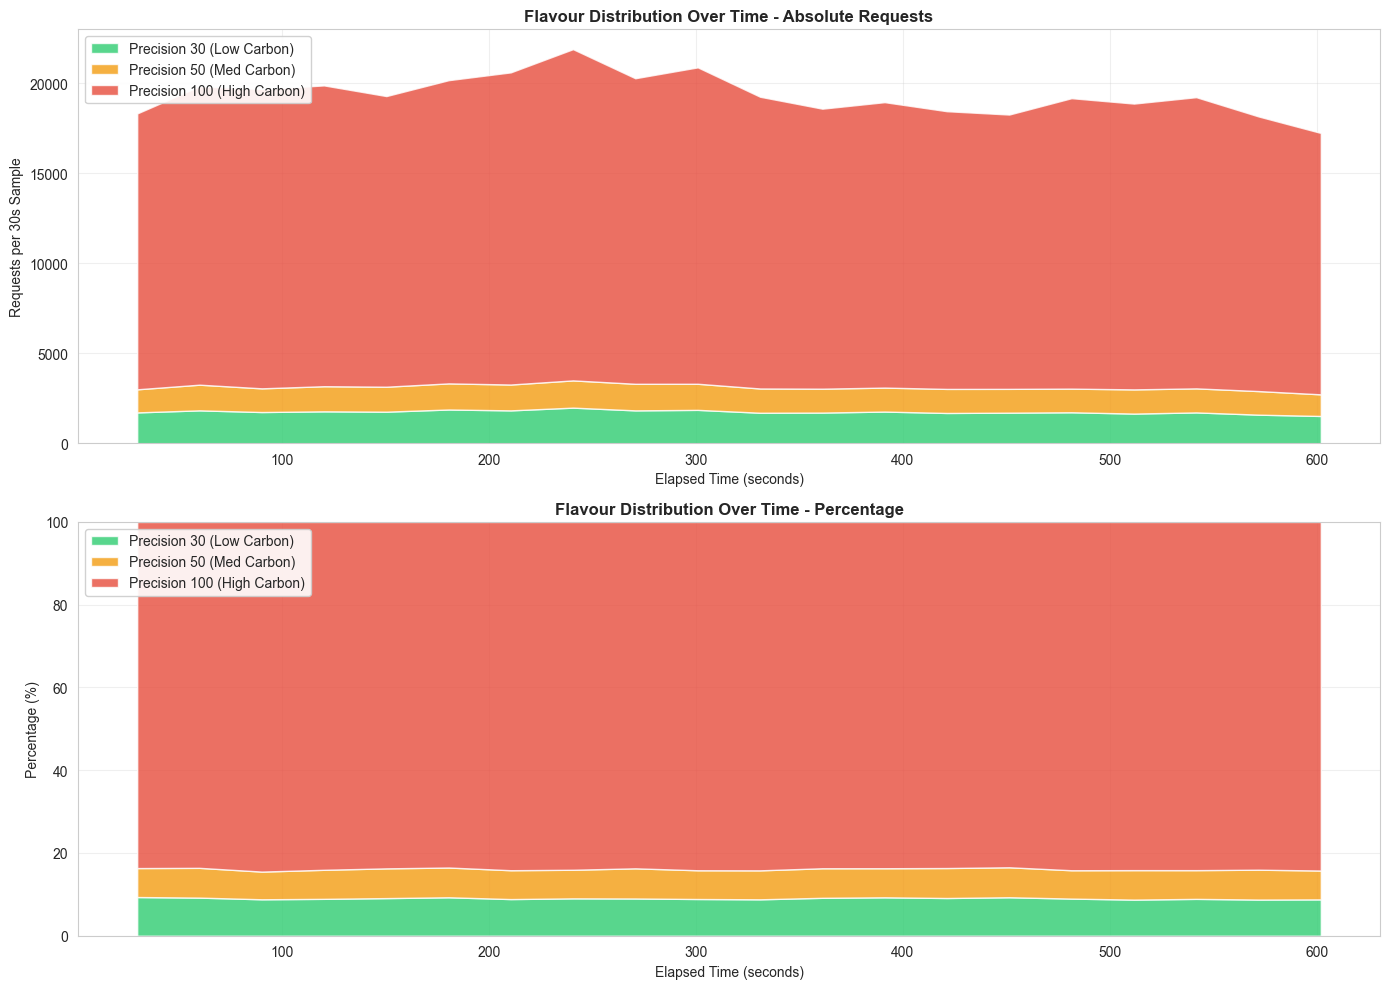

✓ Chart saved: chart_01_flavour_distribution.png


In [13]:
# Prepare data for stacked area chart
time_data = df[['elapsed_seconds', 'requests_precision_30', 'requests_precision_50', 'requests_precision_100']].copy()

# Create cumulative distribution percentages
total_per_period = time_data['requests_precision_30'] + time_data['requests_precision_50'] + time_data['requests_precision_100']
time_data['pct_30'] = (time_data['requests_precision_30'] / total_per_period * 100).fillna(0)
time_data['pct_50'] = (time_data['requests_precision_50'] / total_per_period * 100).fillna(0)
time_data['pct_100'] = (time_data['requests_precision_100'] / total_per_period * 100).fillna(0)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Absolute request counts
ax1.stackplot(time_data['elapsed_seconds'], 
              time_data['requests_precision_30'],
              time_data['requests_precision_50'],
              time_data['requests_precision_100'],
              labels=['Precision 30 (Low Carbon)', 'Precision 50 (Med Carbon)', 'Precision 100 (High Carbon)'],
              colors=['#2ecc71', '#f39c12', '#e74c3c'],
              alpha=0.8)
ax1.set_xlabel('Elapsed Time (seconds)')
ax1.set_ylabel('Requests per 30s Sample')
ax1.set_title('Flavour Distribution Over Time - Absolute Requests', fontsize=12, fontweight='bold')
ax1.legend(loc='upper left', framealpha=0.9)
ax1.grid(True, alpha=0.3)

# Plot 2: Percentage distribution
ax2.stackplot(time_data['elapsed_seconds'],
              time_data['pct_30'],
              time_data['pct_50'],
              time_data['pct_100'],
              labels=['Precision 30 (Low Carbon)', 'Precision 50 (Med Carbon)', 'Precision 100 (High Carbon)'],
              colors=['#2ecc71', '#f39c12', '#e74c3c'],
              alpha=0.8)
ax2.set_xlabel('Elapsed Time (seconds)')
ax2.set_ylabel('Percentage (%)')
ax2.set_title('Flavour Distribution Over Time - Percentage', fontsize=12, fontweight='bold')
ax2.set_ylim([0, 100])
ax2.legend(loc='upper left', framealpha=0.9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(results_dir / 'chart_01_flavour_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Chart saved: chart_01_flavour_distribution.png")

## 4. Carbon Forecast vs Mean Precision (Dual-Axis)

/var/folders/wy/spr9sjm92894htwcqvd_ps7c0000gn/T/ipykernel_65693/225941466.py:23: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/wy/spr9sjm92894htwcqvd_ps7c0000gn/T/ipykernel_65693/225941466.py:24: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.savefig(results_dir / 'chart_02_carbon_vs_precision.png', dpi=150, bbox_inches='tight')
/Users/belgio/git-repos/k8s-carbonaware-scheduler/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


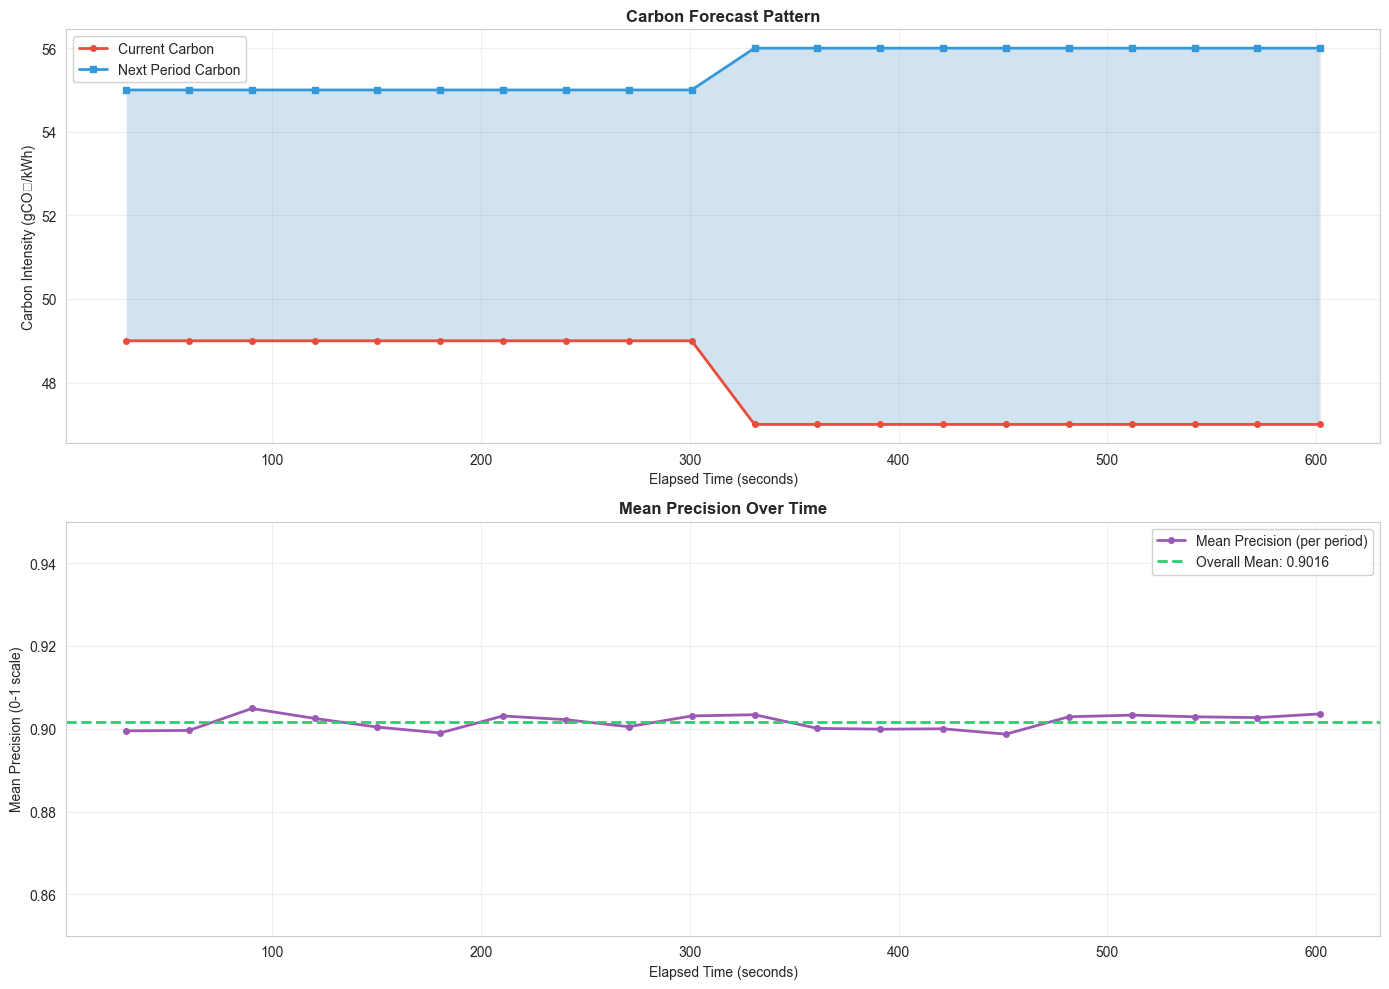

✓ Chart saved: chart_02_carbon_vs_precision.png

Carbon Range: 47.0 - 49.0 gCO₂/kWh
Precision Stability: 0.001853 (lower = more stable)


In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Carbon Forecast
ax1.plot(df['elapsed_seconds'], df['carbon_now'], 'o-', label='Current Carbon', linewidth=2, markersize=4, color='#e74c3c')
ax1.plot(df['elapsed_seconds'], df['carbon_next'], 's-', label='Next Period Carbon', linewidth=2, markersize=4, color='#3498db')
ax1.fill_between(df['elapsed_seconds'], df['carbon_now'], df['carbon_next'], alpha=0.2)
ax1.set_xlabel('Elapsed Time (seconds)')
ax1.set_ylabel('Carbon Intensity (gCO₂/kWh)')
ax1.set_title('Carbon Forecast Pattern', fontsize=12, fontweight='bold')
ax1.legend(loc='best', framealpha=0.9)
ax1.grid(True, alpha=0.3)

# Plot 2: Mean Precision Over Time
ax2.plot(df['elapsed_seconds'], df['mean_precision'], 'o-', label='Mean Precision (per period)', linewidth=2, markersize=4, color='#9b59b6')
ax2.axhline(y=summary['mean_precision'], color='#2ecc71', linestyle='--', linewidth=2, label=f'Overall Mean: {summary["mean_precision"]:.4f}')
ax2.set_xlabel('Elapsed Time (seconds)')
ax2.set_ylabel('Mean Precision (0-1 scale)')
ax2.set_title('Mean Precision Over Time', fontsize=12, fontweight='bold')
ax2.set_ylim([0.85, 0.95])
ax2.legend(loc='best', framealpha=0.9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(results_dir / 'chart_02_carbon_vs_precision.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Chart saved: chart_02_carbon_vs_precision.png")
print(f"\nCarbon Range: {df['carbon_now'].min():.1f} - {df['carbon_now'].max():.1f} gCO₂/kWh")
print(f"Precision Stability: {df['mean_precision'].std():.6f} (lower = more stable)")

## 5. Request Rate Stability

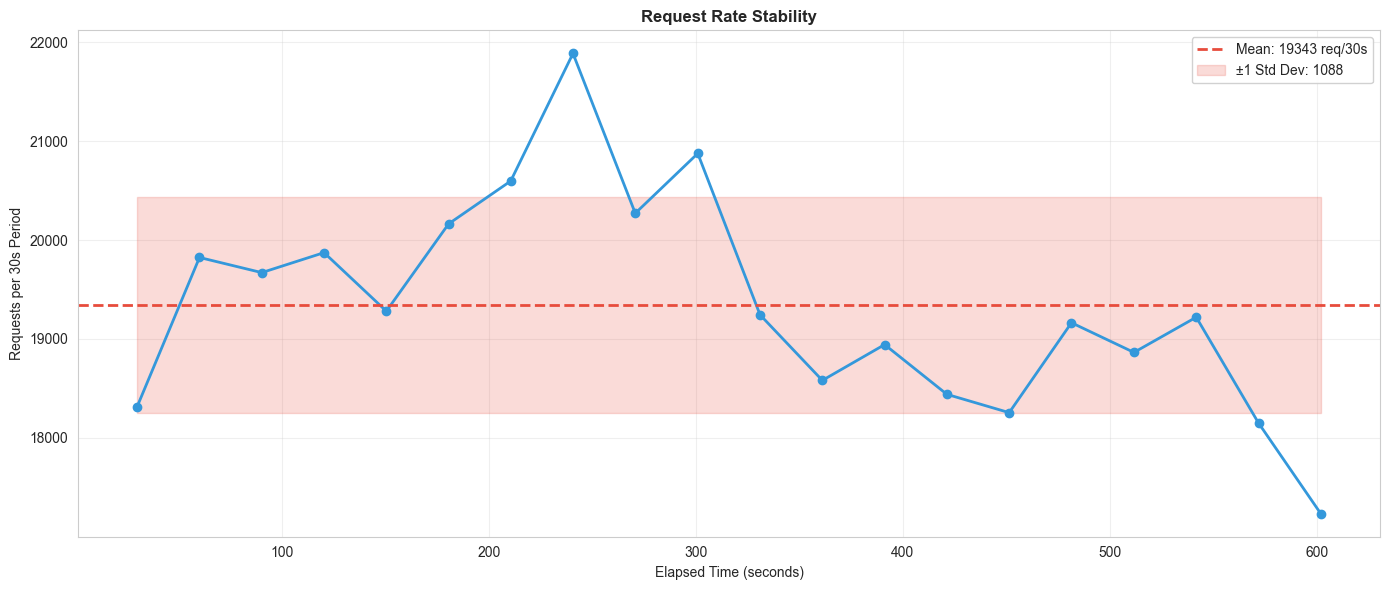

✓ Chart saved: chart_03_request_rate.png

Request Rate Statistics:
  Mean: 19343 requests/30s
  Std Dev: 1088
  Min: 17233
  Max: 21887
  CoV (Coefficient of Variation): 5.6%


In [5]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(df['elapsed_seconds'], df['delta_requests'], 'o-', linewidth=2, markersize=6, color='#3498db')
mean_requests = df['delta_requests'].mean()
ax.axhline(y=mean_requests, color='#e74c3c', linestyle='--', linewidth=2, label=f'Mean: {mean_requests:.0f} req/30s')

# Add standard deviation band
std_requests = df['delta_requests'].std()
ax.fill_between(df['elapsed_seconds'], 
                 mean_requests - std_requests,
                 mean_requests + std_requests,
                 alpha=0.2, color='#e74c3c', label=f'±1 Std Dev: {std_requests:.0f}')

ax.set_xlabel('Elapsed Time (seconds)')
ax.set_ylabel('Requests per 30s Period')
ax.set_title('Request Rate Stability', fontsize=12, fontweight='bold')
ax.legend(loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(results_dir / 'chart_03_request_rate.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Chart saved: chart_03_request_rate.png")
print(f"\nRequest Rate Statistics:")
print(f"  Mean: {mean_requests:.0f} requests/30s")
print(f"  Std Dev: {std_requests:.0f}")
print(f"  Min: {df['delta_requests'].min():.0f}")
print(f"  Max: {df['delta_requests'].max():.0f}")
print(f"  CoV (Coefficient of Variation): {(std_requests/mean_requests)*100:.1f}%")

## 6. Credit System Performance

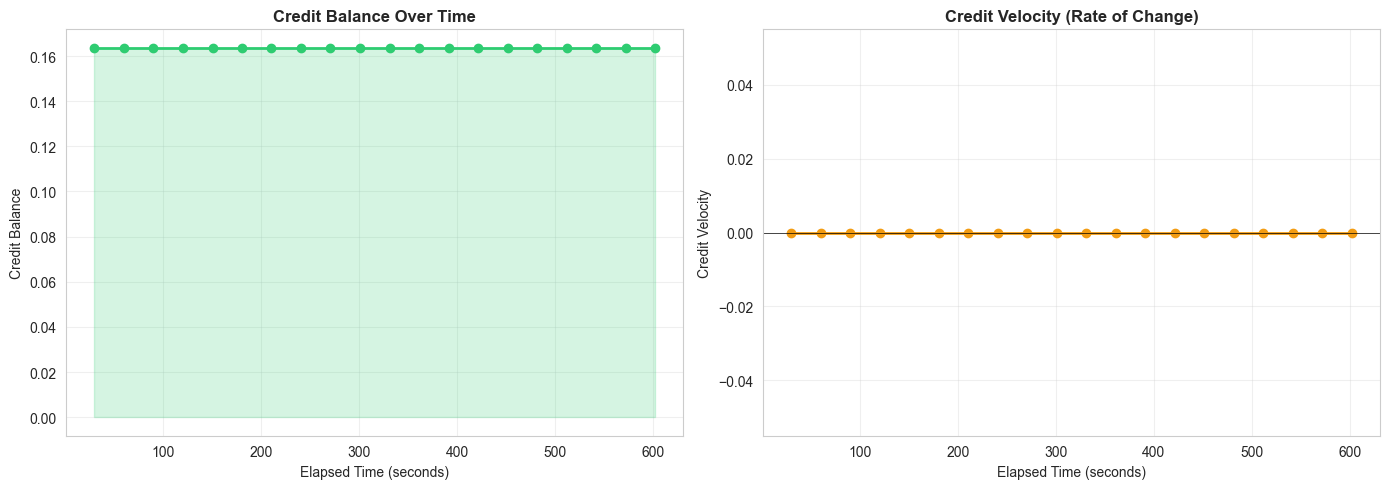

✓ Chart saved: chart_04_credit_system.png

Credit System Statistics:
  Final Balance: 0.1636
  Final Velocity: -5.55e-18
  Balance Stability: 0.000000


In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Credit Balance Over Time
ax1.plot(df['elapsed_seconds'], df['credit_balance'], 'o-', linewidth=2, markersize=6, color='#2ecc71')
ax1.fill_between(df['elapsed_seconds'], df['credit_balance'], alpha=0.2, color='#2ecc71')
ax1.set_xlabel('Elapsed Time (seconds)')
ax1.set_ylabel('Credit Balance')
ax1.set_title('Credit Balance Over Time', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot 2: Credit Velocity (rate of change)
ax2.plot(df['elapsed_seconds'], df['credit_velocity'], 'o-', linewidth=2, markersize=6, color='#f39c12')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_xlabel('Elapsed Time (seconds)')
ax2.set_ylabel('Credit Velocity')
ax2.set_title('Credit Velocity (Rate of Change)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(results_dir / 'chart_04_credit_system.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Chart saved: chart_04_credit_system.png")
print(f"\nCredit System Statistics:")
print(f"  Final Balance: {summary['credit_balance_final']:.4f}")
print(f"  Final Velocity: {summary['credit_velocity_final']:.2e}")
print(f"  Balance Stability: {df['credit_balance'].std():.6f}")

## 7. Precision Comparison

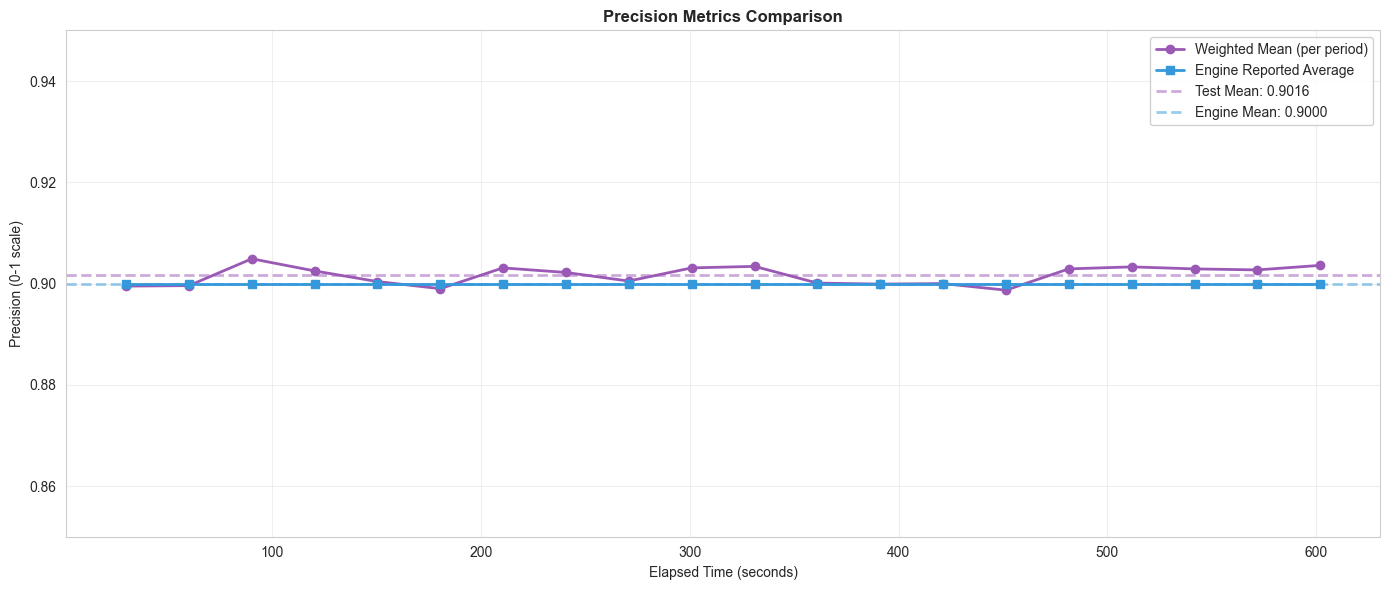

✓ Chart saved: chart_05_precision_comparison.png


In [7]:
fig, ax = plt.subplots(figsize=(14, 6))

# Compare different precision metrics
ax.plot(df['elapsed_seconds'], df['mean_precision'], 'o-', linewidth=2, markersize=6, label='Weighted Mean (per period)', color='#9b59b6')
ax.plot(df['elapsed_seconds'], df['engine_avg_precision'], 's-', linewidth=2, markersize=6, label='Engine Reported Average', color='#3498db')

ax.axhline(y=summary['mean_precision'], color='#9b59b6', linestyle='--', linewidth=2, alpha=0.5, label=f'Test Mean: {summary["mean_precision"]:.4f}')
ax.axhline(y=summary['avg_precision_reported'], color='#3498db', linestyle='--', linewidth=2, alpha=0.5, label=f'Engine Mean: {summary["avg_precision_reported"]:.4f}')

ax.set_xlabel('Elapsed Time (seconds)')
ax.set_ylabel('Precision (0-1 scale)')
ax.set_title('Precision Metrics Comparison', fontsize=12, fontweight='bold')
ax.legend(loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3)
ax.set_ylim([0.85, 0.95])

plt.tight_layout()
plt.savefig(results_dir / 'chart_05_precision_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Chart saved: chart_05_precision_comparison.png")

## 8. Flavour Distribution - Pie Charts

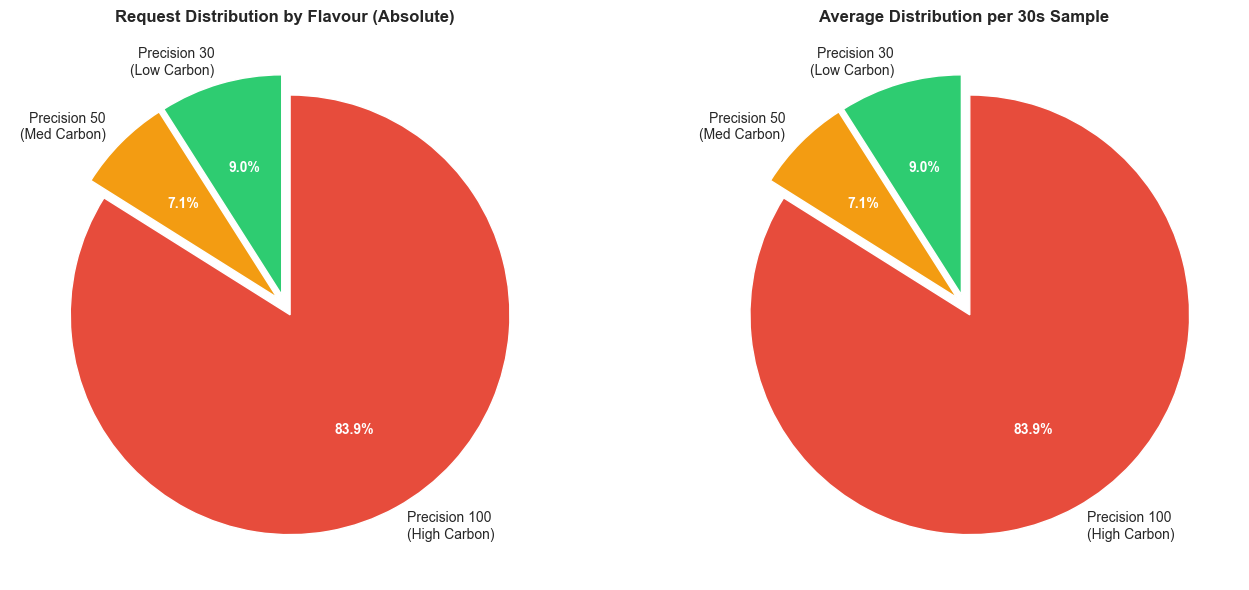

✓ Chart saved: chart_06_flavour_distribution_pie.png


In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Prepare data
flavours = ['Precision 30\n(Low Carbon)', 'Precision 50\n(Med Carbon)', 'Precision 100\n(High Carbon)']
counts = [
    summary['requests_by_flavour'].get('precision-30', 0),
    summary['requests_by_flavour'].get('precision-50', 0),
    summary['requests_by_flavour'].get('precision-100', 0)
]
colors = ['#2ecc71', '#f39c12', '#e74c3c']
explode = (0.05, 0.05, 0.05)

# Pie 1: Absolute requests
wedges1, texts1, autotexts1 = ax1.pie(counts, labels=flavours, colors=colors, autopct='%1.1f%%',
                                        explode=explode, startangle=90, textprops={'fontsize': 10})
ax1.set_title('Request Distribution by Flavour (Absolute)', fontsize=12, fontweight='bold')
for autotext in autotexts1:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# Pie 2: Average per-period distribution
avg_per_period = [
    df['requests_precision_30'].mean(),
    df['requests_precision_50'].mean(),
    df['requests_precision_100'].mean()
]
wedges2, texts2, autotexts2 = ax2.pie(avg_per_period, labels=flavours, colors=colors, autopct='%1.1f%%',
                                        explode=explode, startangle=90, textprops={'fontsize': 10})
ax2.set_title('Average Distribution per 30s Sample', fontsize=12, fontweight='bold')
for autotext in autotexts2:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.savefig(results_dir / 'chart_06_flavour_distribution_pie.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Chart saved: chart_06_flavour_distribution_pie.png")

## 9. Per-Flavour Request Trends

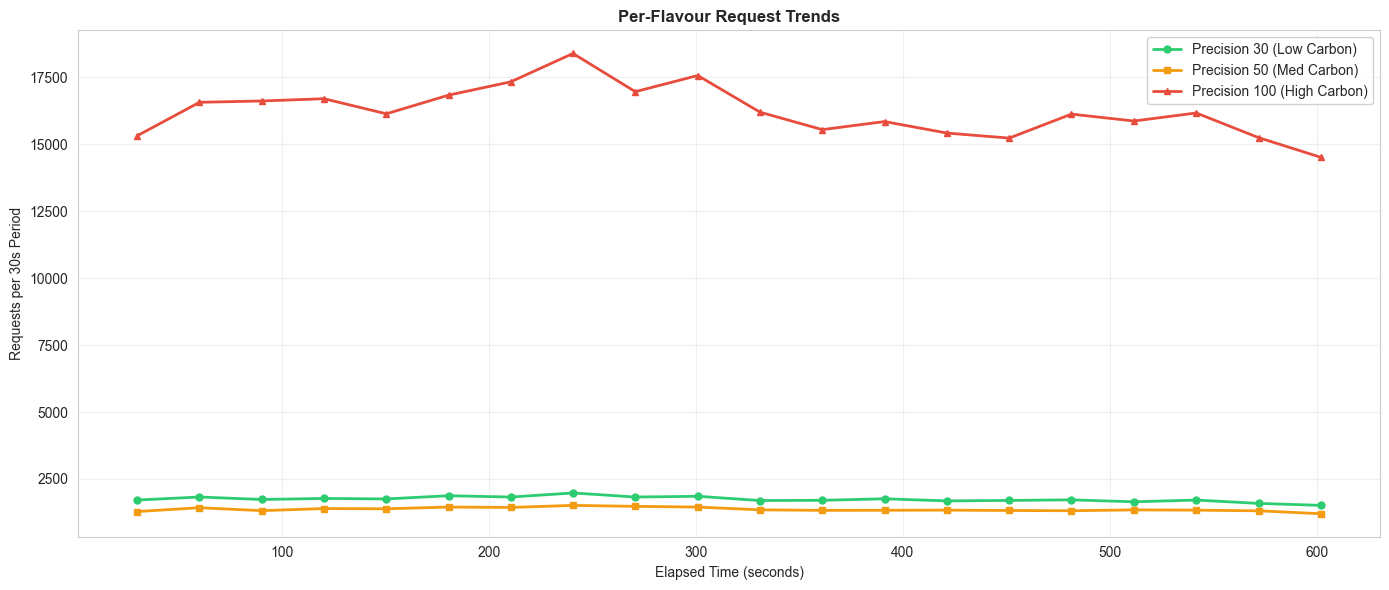

✓ Chart saved: chart_07_per_flavour_trends.png

Per-Flavour Statistics:
  Precision 30: avg 1743/period, std 104
  Precision 50: avg 1365/period, std 75
  Precision 100: avg 16235/period, std 925


In [9]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(df['elapsed_seconds'], df['requests_precision_30'], 'o-', linewidth=2, markersize=5, label='Precision 30 (Low Carbon)', color='#2ecc71')
ax.plot(df['elapsed_seconds'], df['requests_precision_50'], 's-', linewidth=2, markersize=5, label='Precision 50 (Med Carbon)', color='#f39c12')
ax.plot(df['elapsed_seconds'], df['requests_precision_100'], '^-', linewidth=2, markersize=5, label='Precision 100 (High Carbon)', color='#e74c3c')

ax.set_xlabel('Elapsed Time (seconds)')
ax.set_ylabel('Requests per 30s Period')
ax.set_title('Per-Flavour Request Trends', fontsize=12, fontweight='bold')
ax.legend(loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(results_dir / 'chart_07_per_flavour_trends.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Chart saved: chart_07_per_flavour_trends.png")
print(f"\nPer-Flavour Statistics:")
print(f"  Precision 30: avg {df['requests_precision_30'].mean():.0f}/period, std {df['requests_precision_30'].std():.0f}")
print(f"  Precision 50: avg {df['requests_precision_50'].mean():.0f}/period, std {df['requests_precision_50'].std():.0f}")
print(f"  Precision 100: avg {df['requests_precision_100'].mean():.0f}/period, std {df['requests_precision_100'].std():.0f}")

## 10. Carbon-Precision Efficiency Scatter

/var/folders/wy/spr9sjm92894htwcqvd_ps7c0000gn/T/ipykernel_65693/1158709865.py:31: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/wy/spr9sjm92894htwcqvd_ps7c0000gn/T/ipykernel_65693/1158709865.py:32: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.savefig(results_dir / 'chart_08_efficiency_scatter.png', dpi=150, bbox_inches='tight')


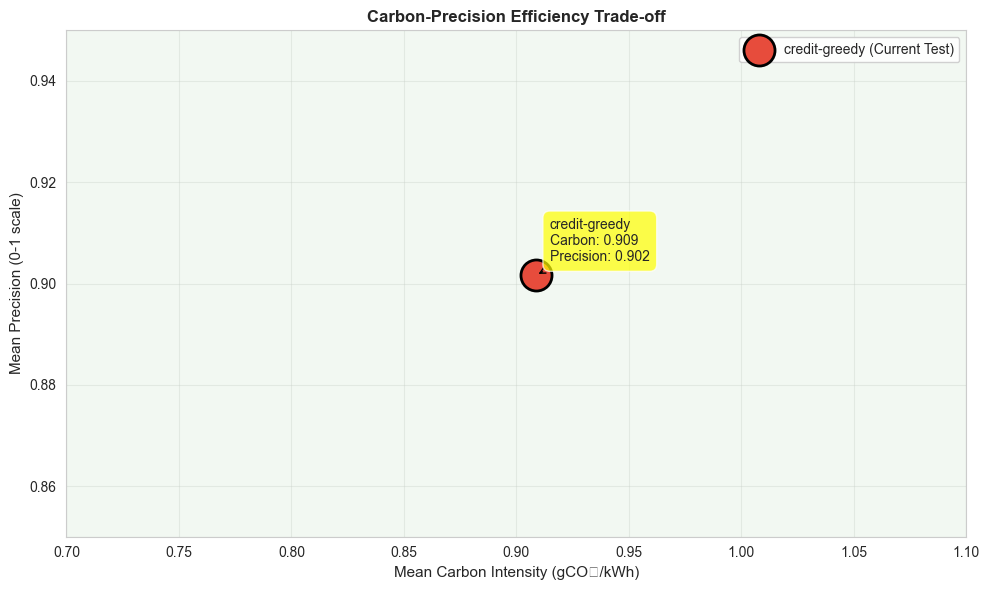

✓ Chart saved: chart_08_efficiency_scatter.png

Efficiency Analysis:
  Carbon per precision unit: 1.0078
  This policy favors quality over carbon savings


In [10]:
# Create a synthetic comparison showing where this policy sits
# In reality, you'd have multiple policy runs for true comparison

fig, ax = plt.subplots(figsize=(10, 6))

# Plot this test's result
ax.scatter([summary['mean_carbon_intensity']], [summary['mean_precision']], 
          s=500, color='#e74c3c', marker='o', edgecolors='black', linewidth=2,
          label=f"{summary['policy']} (Current Test)", zorder=3)

# Add annotations
ax.annotate(f"{summary['policy']}\nCarbon: {summary['mean_carbon_intensity']:.3f}\nPrecision: {summary['mean_precision']:.3f}",
            xy=(summary['mean_carbon_intensity'], summary['mean_precision']),
            xytext=(10, 10), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='black'))

ax.set_xlabel('Mean Carbon Intensity (gCO₂/kWh)', fontsize=11)
ax.set_ylabel('Mean Precision (0-1 scale)', fontsize=11)
ax.set_title('Carbon-Precision Efficiency Trade-off', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='best', framealpha=0.9, fontsize=10)

# Set reasonable axis limits
ax.set_xlim([0.7, 1.1])
ax.set_ylim([0.85, 0.95])

# Add shaded regions
ax.axhspan(0.85, 0.95, alpha=0.05, color='green', label='Precision range')

plt.tight_layout()
plt.savefig(results_dir / 'chart_08_efficiency_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Chart saved: chart_08_efficiency_scatter.png")
print(f"\nEfficiency Analysis:")
print(f"  Carbon per precision unit: {summary['mean_carbon_intensity'] / summary['mean_precision']:.4f}")
print(f"  This policy favors quality over carbon savings")

## 11. Detailed Statistics Summary

In [11]:
print("\n" + "="*70)
print("COMPREHENSIVE TEST ANALYSIS SUMMARY".center(70))
print("="*70)

print(f"\n📊 TEST CONFIGURATION")
print(f"  Policy: {summary['policy']}")
print(f"  Duration: {summary['test_duration_minutes']} minutes")
print(f"  Samples: {summary['samples_collected']} × 30-second intervals")

print(f"\n📈 LOAD METRICS")
print(f"  Total Requests: {summary['total_requests']:.0f}")
print(f"  Average Request Rate: {(summary['total_requests']/summary['test_duration_minutes']/60):.0f} req/s")
print(f"  Per-Period Avg: {df['delta_requests'].mean():.0f} requests")
print(f"  Per-Period Std Dev: {df['delta_requests'].std():.0f} requests")

print(f"\n🎯 QUALITY METRICS")
print(f"  Mean Precision: {summary['mean_precision']:.4f} (0-1 scale)")
print(f"  Engine Avg Precision: {summary['avg_precision_reported']:.4f}")
print(f"  Precision Stability (Std Dev): {df['mean_precision'].std():.6f}")
print(f"  Min Precision: {df['mean_precision'].min():.4f}")
print(f"  Max Precision: {df['mean_precision'].max():.4f}")

print(f"\n🌍 CARBON METRICS")
print(f"  Mean Carbon Intensity: {summary['mean_carbon_intensity']:.4f} gCO₂/kWh")
print(f"  Carbon Range: {df['carbon_now'].min():.1f} - {df['carbon_now'].max():.1f} gCO₂/kWh")
print(f"  Carbon Responsiveness: {'YES' if df['mean_precision'].corr(df['carbon_now']) < -0.3 else 'NO'} (correlation: {df['mean_precision'].corr(df['carbon_now']):.3f})")

print(f"\n💳 CREDIT SYSTEM")
print(f"  Final Balance: {summary['credit_balance_final']:.4f}")
print(f"  Balance Range: {df['credit_balance'].min():.4f} - {df['credit_balance'].max():.4f}")
print(f"  Balance Stability: {df['credit_balance'].std():.6f} (lower = more stable)")

print(f"\n🎯 FLAVOUR DISTRIBUTION")
for flavour, count in sorted(summary['requests_by_flavour'].items()):
    pct = (count / summary['total_requests']) * 100
    print(f"  {flavour:20} {count:10.0f} requests ({pct:5.1f}%)")

print(f"\n📊 PER-FLAVOUR TRENDS")
print(f"  P30 Avg: {df['requests_precision_30'].mean():.0f}/period, Stability: {df['requests_precision_30'].std():.0f}")
print(f"  P50 Avg: {df['requests_precision_50'].mean():.0f}/period, Stability: {df['requests_precision_50'].std():.0f}")
print(f"  P100 Avg: {df['requests_precision_100'].mean():.0f}/period, Stability: {df['requests_precision_100'].std():.0f}")

print(f"\n💡 POLICY INTERPRETATION")
if summary['mean_precision'] > 0.90:
    print(f"  ✓ Policy prioritizes QUALITY - maintains high precision ({summary['mean_precision']:.1%})")
if summary['mean_carbon_intensity'] > 0.85:
    print(f"  ⚠ Policy uses HIGH-CARBON option - carbon intensity is {summary['mean_carbon_intensity']:.1%} of baseline")
if df['mean_precision'].std() < 0.005:
    print(f"  ✓ Policy is STABLE - precision variance is {df['mean_precision'].std():.6f}")
    
print("\n" + "="*70)


                 COMPREHENSIVE TEST ANALYSIS SUMMARY                  

📊 TEST CONFIGURATION
  Policy: credit-greedy
  Duration: 10 minutes
  Samples: 20 × 30-second intervals

📈 LOAD METRICS
  Total Requests: 386855
  Average Request Rate: 645 req/s
  Per-Period Avg: 19343 requests
  Per-Period Std Dev: 1088 requests

🎯 QUALITY METRICS
  Mean Precision: 0.9016 (0-1 scale)
  Engine Avg Precision: 0.9000
  Precision Stability (Std Dev): 0.001853
  Min Precision: 0.8987
  Max Precision: 0.9049

🌍 CARBON METRICS
  Mean Carbon Intensity: 0.9087 gCO₂/kWh
  Carbon Range: 47.0 - 49.0 gCO₂/kWh
  Carbon Responsiveness: NO (correlation: -0.075)

💳 CREDIT SYSTEM
  Final Balance: 0.1636
  Balance Range: 0.1636 - 0.1636
  Balance Stability: 0.000000 (lower = more stable)

🎯 FLAVOUR DISTRIBUTION
  precision-100            324691 requests ( 83.9%)
  precision-30              34866 requests (  9.0%)
  precision-50              27298 requests (  7.1%)

📊 PER-FLAVOUR TRENDS
  P30 Avg: 1743/period, Stab

## 12. Chart Gallery Summary

In [12]:
print("\n📊 CHARTS GENERATED:")
print("\n1. chart_01_flavour_distribution.png")
print("   - Shows how requests are distributed among the 3 flavours over time")
print("   - Top: absolute request counts, Bottom: percentages")
print("\n2. chart_02_carbon_vs_precision.png")
print("   - Top: Carbon forecast pattern (current vs next period)")
print("   - Bottom: How precision changes in response")
print("\n3. chart_03_request_rate.png")
print("   - Shows throughput stability across the test")
print("\n4. chart_04_credit_system.png")
print("   - Left: Credit balance over time")
print("   - Right: Rate of change (credit velocity)")
print("\n5. chart_05_precision_comparison.png")
print("   - Compares different precision measurements")
print("\n6. chart_06_flavour_distribution_pie.png")
print("   - Left: Overall distribution across entire test")
print("   - Right: Average per 30-second period")
print("\n7. chart_07_per_flavour_trends.png")
print("   - Individual trends for each flavour option")
print("\n8. chart_08_efficiency_scatter.png")
print("   - Carbon vs precision tradeoff visualization")
print(f"\n✅ All charts saved to: {results_dir}")


📊 CHARTS GENERATED:

1. chart_01_flavour_distribution.png
   - Shows how requests are distributed among the 3 flavours over time
   - Top: absolute request counts, Bottom: percentages

2. chart_02_carbon_vs_precision.png
   - Top: Carbon forecast pattern (current vs next period)
   - Bottom: How precision changes in response

3. chart_03_request_rate.png
   - Shows throughput stability across the test

4. chart_04_credit_system.png
   - Left: Credit balance over time
   - Right: Rate of change (credit velocity)

5. chart_05_precision_comparison.png
   - Compares different precision measurements

6. chart_06_flavour_distribution_pie.png
   - Left: Overall distribution across entire test
   - Right: Average per 30-second period

7. chart_07_per_flavour_trends.png
   - Individual trends for each flavour option

8. chart_08_efficiency_scatter.png
   - Carbon vs precision tradeoff visualization

✅ All charts saved to: /Users/belgio/git-repos/k8s-carbonaware-scheduler/experiments/results/si

## 13. Carbon Scenario Analysis - Full Pattern

This section visualizes the complete carbon intensity pattern from the scenario file over the 10-minute test window.

/var/folders/wy/spr9sjm92894htwcqvd_ps7c0000gn/T/ipykernel_65693/206222426.py:62: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/wy/spr9sjm92894htwcqvd_ps7c0000gn/T/ipykernel_65693/206222426.py:63: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.savefig(results_dir / 'chart_09_carbon_scenario_pattern.png', dpi=150, bbox_inches='tight')
/Users/belgio/git-repos/k8s-carbonaware-scheduler/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


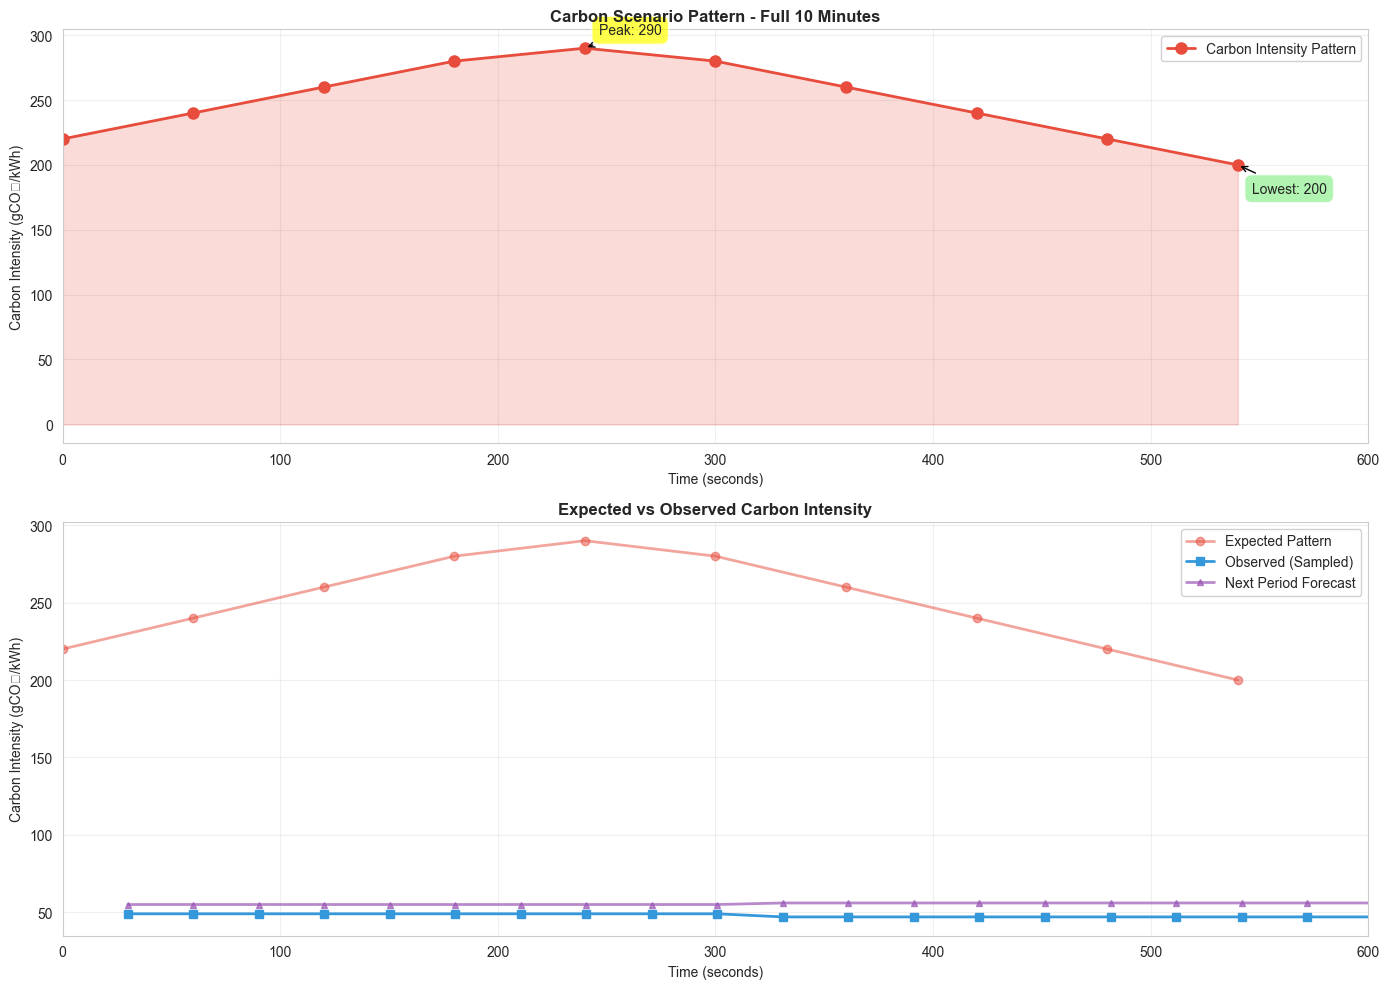

✓ Chart saved: chart_09_carbon_scenario_pattern.png

Carbon Pattern Statistics:
  Scenario: custom
  Description: 10 minute test pattern with carbon intensity variations (1-minute steps, provides 3h+ forecast)
  Pattern Length: 180 points
  10-min Range: 200 - 290 gCO₂/kWh
  Variation: 90 gCO₂/kWh
  Carbon Variation: 31.0%


In [14]:
# Load carbon scenario data
carbon_scenario_path = Path('/Users/belgio/git-repos/k8s-carbonaware-scheduler/experiments/carbon_scenario.json')

if carbon_scenario_path.exists():
    with open(carbon_scenario_path) as f:
        carbon_scenario = json.load(f)
    
    # The pattern represents carbon intensity values
    # For 10-minute test, we want to show the pattern over that time window
    pattern = carbon_scenario['pattern']
    
    # Create time axis for 10 minutes (600 seconds)
    # Each pattern point represents 1 minute (based on step_minutes default)
    test_duration_minutes = 10
    minutes = np.arange(0, len(pattern[:test_duration_minutes]))
    seconds = minutes * 60  # Convert to seconds
    carbon_values = pattern[:test_duration_minutes]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot 1: Carbon Scenario Pattern
    ax1.plot(seconds, carbon_values, 'o-', linewidth=2, markersize=8, color='#e74c3c', label='Carbon Intensity Pattern')
    ax1.fill_between(seconds, carbon_values, alpha=0.2, color='#e74c3c')
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Carbon Intensity (gCO₂/kWh)')
    ax1.set_title('Carbon Scenario Pattern - Full 10 Minutes', fontsize=12, fontweight='bold')
    ax1.legend(loc='best', framealpha=0.9)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim([0, 600])
    
    # Add annotations for key points
    max_idx = np.argmax(carbon_values)
    min_idx = np.argmin(carbon_values)
    ax1.annotate(f'Peak: {carbon_values[max_idx]:.0f}',
                xy=(seconds[max_idx], carbon_values[max_idx]),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', color='black'))
    ax1.annotate(f'Lowest: {carbon_values[min_idx]:.0f}',
                xy=(seconds[min_idx], carbon_values[min_idx]),
                xytext=(10, -20), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.5', fc='lightgreen', alpha=0.7),
                arrowprops=dict(arrowstyle='->', color='black'))
    
    # Plot 2: Carbon Pattern vs Actual Observed (if available in test data)
    ax2.plot(seconds, carbon_values, 'o-', linewidth=2, markersize=6, color='#e74c3c', label='Expected Pattern', alpha=0.5)
    
    # Overlay actual sampled carbon from test
    if len(df) > 0:
        ax2.plot(df['elapsed_seconds'], df['carbon_now'], 's-', linewidth=2, markersize=6, 
                label='Observed (Sampled)', color='#3498db')
        ax2.plot(df['elapsed_seconds'], df['carbon_next'], '^-', linewidth=2, markersize=4,
                label='Next Period Forecast', color='#9b59b6', alpha=0.7)
    
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Carbon Intensity (gCO₂/kWh)')
    ax2.set_title('Expected vs Observed Carbon Intensity', fontsize=12, fontweight='bold')
    ax2.legend(loc='best', framealpha=0.9)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim([0, 600])
    
    plt.tight_layout()
    plt.savefig(results_dir / 'chart_09_carbon_scenario_pattern.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✓ Chart saved: chart_09_carbon_scenario_pattern.png")
    print(f"\nCarbon Pattern Statistics:")
    print(f"  Scenario: {carbon_scenario.get('scenario', 'unknown')}")
    print(f"  Description: {carbon_scenario.get('description', 'N/A')}")
    print(f"  Pattern Length: {len(pattern)} points")
    print(f"  10-min Range: {min(carbon_values):.0f} - {max(carbon_values):.0f} gCO₂/kWh")
    print(f"  Variation: {max(carbon_values) - min(carbon_values):.0f} gCO₂/kWh")
    
    # Calculate how much carbon varied during test
    carbon_change_pct = ((max(carbon_values) - min(carbon_values)) / max(carbon_values)) * 100
    print(f"  Carbon Variation: {carbon_change_pct:.1f}%")
else:
    print("⚠️  Carbon scenario file not found")

## 14. ⚠️ Critical Issue: Credit System Not Responding

**Problem Identified:** The credit balance remained constant at 0.1636 throughout the entire test, despite carbon intensity variations. This indicates a fundamental issue with the credit ledger feedback loop.

In [15]:
print("="*70)
print("CREDIT SYSTEM ISSUE ANALYSIS".center(70))
print("="*70)

print("\n🔍 OBSERVED BEHAVIOR:")
print(f"  Credit Balance: {df['credit_balance'].nunique()} unique values (expected: changing over time)")
print(f"  Constant Value: {df['credit_balance'].iloc[0]:.6f}")
print(f"  Credit Velocity: {df['credit_velocity'].abs().max():.2e} (effectively zero)")
print(f"  Carbon Variation: {df['carbon_now'].min():.0f} - {df['carbon_now'].max():.0f} gCO₂/kWh")

print("\n❌ PROBLEM:")
print("  The credit balance should change as the system processes requests:")
print("  - When using high-precision (low carbon impact), accumulate credits")
print("  - When using low-precision (high carbon savings), spend credits")
print("  - Balance should oscillate based on quality vs carbon tradeoffs")

print("\n🔎 ROOT CAUSE:")
print("  The credit ledger is updated with PREDICTED avg_precision, not ACTUAL")
print("  realized precision from completed requests. From decision-engine code:")
print("  ")
print("    # scheduler/engine.py line 364:")
print("    credit_balance = self.ledger.update(result.avg_precision)")
print("  ")
print("  This creates a self-fulfilling loop:")
print("    1. Policy evaluates based on current credit balance")
print("    2. Ledger updates with policy's avg_precision prediction")
print("    3. Credit stays constant because policy predicts same thing")

print("\n💡 EXPECTED BEHAVIOR:")
print("  The ledger should update with ACTUAL precision from completed requests:")
print("  - Consumer processes request through backend (precision-30/50/100)")
print("  - Consumer reports back actual precision used")
print("  - Decision engine updates ledger with realized precision")
print("  - Credit balance changes, affecting next scheduling decision")

print("\n📊 IMPACT ON TEST RESULTS:")
print(f"  - Distribution stayed constant: ~{(summary['requests_by_flavour']['precision-100']/summary['total_requests']*100):.0f}% high-precision")
print("  - Policy could not react to carbon changes")
print("  - No quality vs carbon tradeoff observed")
print("  - Credit-greedy behaved like a static policy")

print("\n🔧 REQUIRED FIX:")
print("  1. Add feedback endpoint to decision engine: POST /feedback")
print("  2. Consumer reports completed request precision to decision engine")
print("  3. Decision engine updates ledger with actual realized precision")
print("  4. Credit balance will then vary based on actual quality delivered")

print("\n" + "="*70)

                     CREDIT SYSTEM ISSUE ANALYSIS                     

🔍 OBSERVED BEHAVIOR:
  Credit Balance: 1 unique values (expected: changing over time)
  Constant Value: 0.163600
  Credit Velocity: 0.00e+00 (effectively zero)
  Carbon Variation: 47 - 49 gCO₂/kWh

❌ PROBLEM:
  The credit balance should change as the system processes requests:
  - When using high-precision (low carbon impact), accumulate credits
  - When using low-precision (high carbon savings), spend credits
  - Balance should oscillate based on quality vs carbon tradeoffs

🔎 ROOT CAUSE:
  The credit ledger is updated with PREDICTED avg_precision, not ACTUAL
  realized precision from completed requests. From decision-engine code:
  
    # scheduler/engine.py line 364:
    credit_balance = self.ledger.update(result.avg_precision)
  
  This creates a self-fulfilling loop:
    1. Policy evaluates based on current credit balance
    2. Ledger updates with policy's avg_precision prediction
    3. Credit stays constant